In [135]:
import cv2
from scipy.ndimage import distance_transform_edt as dist
import IPython.display 
import importlib
import skimage.io as imgio
import numpy as np
import os
import torch
import torch.nn.functional as F
import math
import re
from matplotlib import pyplot as plt
from scipy import ndimage
from topoloss4neurons.networks import UNet
import networktraining as nt
import os
import tifffile
import skimage
from util_funcs import getCube, findCubes, loadPred
from tqdm import tqdm
%matplotlib inline
# %matplotlib notebook

--> findCubes gives only the cube positioning (not even the coords) <br>
--> getCube gets the cube itself<br>
--> the min max in dims/max/man is to transpose the findCubes positioning to the cube itself with the for loop.

In [672]:
def createRGB(im, pred, lmbd=0.5):
    
    g_channel = (pred.max() - pred)/pred.max()

    finalim = np.zeros((im.shape[0], im.shape[1], im.shape[2], 3))
    finalim[:,:,:,0] = (im / im.max() * 255).astype(np.uint8)
    finalim[:,:,:,2] = (im / im.max() * 255).astype(np.uint8)
    #finalim[:,:,:,1] = (lmbd * g_channel * 255).astype(np.uint8)
    finalim[:,:,:,1] = (g_channel * 255).astype(np.uint8)
    return finalim

def createGray(im, pred, lmbd=0.5):
    
    pred = (pred.max() - pred)/pred.max()

    im = (im / im.max() * 255).astype(np.uint8)
    
    finalim = ((lmbd*pred*255) + im)
    finalim /= finalim.max()/255

    return finalim

def createRGB_clip_expo(im, pred, lmbd=0.5):
    
    g_channel = np.clip(pred, a_min=pred.min(), a_max=6)
    g_channel = np.array((g_channel.max() - g_channel)/g_channel.max())
    g_channel = np.power(g_channel, 2)
    g_channel /= g_channel.max()
    
    
    finalim = np.zeros((im.shape[0], im.shape[1], im.shape[2], 3))
    finalim[:,:,:,0] = im.astype(np.int16)
    finalim[:,:,:,2] = im.astype(np.int16)
    finalim[:,:,:,1] = (g_channel * 65535 * 0.8).astype(np.int16)
    
    return finalim.astype(np.int16)

In [138]:
cubes = findCubes(175)

dims = np.array(cubes).max(0) - np.array(cubes).min(0) +1
maxs = np.array(cubes).max(0)
mins = np.array(cubes).min(0)

In [93]:
###### brains that have neurones ######

for i in tqdm(range(mins[0],maxs[0]+1)):
    for j in range(mins[1],maxs[1]+1):
        for k in range(mins[2],maxs[2]+1):
            try:
                loadPred(175, [i,j,k])
                print([i,j,k])
                break
            except:
                continue

  0%|                                                    | 0/38 [00:00<?, ?it/s]

[4, 39, 3]
[4, 40, 3]


  3%|█▏                                          | 1/38 [00:03<02:19,  3.78s/it]

[5, 38, 3]
[5, 39, 3]
[5, 40, 3]


  5%|██▎                                         | 2/38 [00:08<02:21,  3.93s/it]

[6, 36, 2]
[6, 38, 2]
[6, 39, 2]


  8%|███▍                                        | 3/38 [00:16<03:04,  5.27s/it]

[7, 35, 1]
[7, 36, 1]
[7, 37, 1]
[7, 38, 1]
[7, 39, 2]


 11%|████▋                                       | 4/38 [00:21<02:54,  5.12s/it]

[8, 32, 1]
[8, 33, 1]
[8, 34, 1]
[8, 35, 1]
[8, 36, 1]
[8, 37, 1]
[8, 38, 1]
[8, 39, 3]


 13%|█████▊                                      | 5/38 [00:32<03:44,  6.82s/it]

[9, 32, 1]
[9, 33, 1]
[9, 34, 1]
[9, 35, 1]
[9, 36, 1]
[9, 37, 1]


 16%|██████▉                                     | 6/38 [00:42<04:09,  7.79s/it]

[9, 39, 1]
[10, 30, 1]
[10, 31, 1]
[10, 32, 1]
[10, 33, 1]
[10, 34, 1]
[10, 35, 1]
[10, 36, 1]
[10, 37, 1]
[10, 38, 1]
[10, 39, 2]
[10, 42, 1]


 18%|████████                                    | 7/38 [00:58<05:21, 10.38s/it]

[10, 43, 1]
[11, 31, 1]
[11, 32, 1]
[11, 33, 1]
[11, 34, 1]
[11, 35, 1]
[11, 36, 1]
[11, 37, 1]
[11, 38, 1]
[11, 39, 1]
[11, 42, 1]


 21%|█████████▎                                  | 8/38 [01:13<05:51, 11.72s/it]

[11, 43, 1]
[12, 30, 2]
[12, 31, 2]
[12, 32, 2]
[12, 33, 1]
[12, 34, 1]
[12, 35, 1]
[12, 36, 1]
[12, 37, 1]
[12, 38, 1]
[12, 39, 1]
[12, 40, 2]
[12, 41, 1]
[12, 42, 1]


 24%|██████████▍                                 | 9/38 [01:31<06:32, 13.55s/it]

[12, 43, 1]
[13, 30, 2]
[13, 31, 2]
[13, 32, 2]
[13, 33, 2]
[13, 34, 2]
[13, 35, 1]
[13, 36, 1]
[13, 37, 1]
[13, 42, 1]


 26%|███████████▎                               | 10/38 [01:45<06:27, 13.82s/it]

[13, 43, 1]
[14, 31, 2]
[14, 32, 1]
[14, 33, 1]
[14, 34, 2]
[14, 35, 2]
[14, 36, 2]
[14, 38, 1]
[14, 39, 1]


 29%|████████████▍                              | 11/38 [01:58<06:03, 13.47s/it]

[14, 43, 1]
[15, 35, 2]
[15, 36, 2]
[15, 37, 1]
[15, 38, 1]
[15, 39, 1]
[15, 40, 1]
[15, 41, 1]
[15, 42, 1]


 32%|█████████████▌                             | 12/38 [02:09<05:34, 12.86s/it]

[15, 43, 1]
[16, 34, 1]
[16, 35, 1]
[16, 36, 1]
[16, 37, 1]
[16, 38, 1]
[16, 39, 1]
[16, 40, 1]
[16, 41, 1]
[16, 42, 1]


 34%|██████████████▋                            | 13/38 [02:23<05:27, 13.09s/it]

[16, 43, 1]
[17, 31, 1]
[17, 32, 1]
[17, 34, 1]
[17, 35, 1]
[17, 36, 1]
[17, 37, 1]
[17, 38, 1]
[17, 39, 1]
[17, 40, 1]
[17, 41, 1]


 37%|███████████████▊                           | 14/38 [02:37<05:24, 13.52s/it]

[17, 42, 1]
[18, 31, 1]
[18, 32, 1]
[18, 33, 1]
[18, 34, 1]
[18, 35, 1]
[18, 36, 1]
[18, 37, 1]
[18, 38, 1]
[18, 39, 1]
[18, 40, 1]


 39%|████████████████▉                          | 15/38 [02:52<05:19, 13.88s/it]

[18, 41, 1]
[19, 31, 1]
[19, 32, 1]
[19, 33, 1]
[19, 34, 1]
[19, 38, 1]
[19, 39, 1]


 42%|██████████████████                         | 16/38 [03:02<04:40, 12.75s/it]

[19, 41, 1]
[20, 33, 1]
[20, 34, 1]


 45%|███████████████████▏                       | 17/38 [03:06<03:28,  9.95s/it]

[21, 33, 1]
[21, 34, 1]


 47%|████████████████████▎                      | 18/38 [03:10<02:44,  8.20s/it]

[22, 33, 1]
[22, 34, 1]


 50%|█████████████████████▌                     | 19/38 [03:12<02:04,  6.54s/it]

[23, 34, 1]


 53%|██████████████████████▋                    | 20/38 [03:14<01:32,  5.14s/it]

[24, 34, 1]


 55%|███████████████████████▊                   | 21/38 [03:16<01:11,  4.21s/it]

[25, 33, 1]
[25, 34, 1]


 58%|████████████████████████▉                  | 22/38 [03:19<01:00,  3.76s/it]

[26, 34, 1]


 61%|██████████████████████████                 | 23/38 [03:21<00:49,  3.31s/it]

[27, 34, 1]


 63%|███████████████████████████▏               | 24/38 [03:24<00:42,  3.07s/it]

[28, 34, 1]


 66%|████████████████████████████▎              | 25/38 [03:26<00:37,  2.86s/it]

[29, 33, 2]
[29, 34, 1]


 68%|█████████████████████████████▍             | 26/38 [03:30<00:39,  3.30s/it]

[30, 33, 2]
[30, 34, 2]


 71%|██████████████████████████████▌            | 27/38 [03:34<00:36,  3.35s/it]

[31, 32, 2]
[31, 33, 2]
[31, 34, 2]


 74%|███████████████████████████████▋           | 28/38 [03:39<00:39,  3.93s/it]

[32, 33, 2]


 76%|████████████████████████████████▊          | 29/38 [03:41<00:30,  3.39s/it]

[33, 33, 1]


 79%|█████████████████████████████████▉         | 30/38 [03:43<00:24,  3.00s/it]

[34, 32, 1]
[34, 33, 1]


 82%|███████████████████████████████████        | 31/38 [03:47<00:22,  3.18s/it]

[35, 32, 1]


 84%|████████████████████████████████████▏      | 32/38 [03:49<00:17,  2.90s/it]

[36, 31, 1]
[36, 32, 1]


 87%|█████████████████████████████████████▎     | 33/38 [03:53<00:16,  3.23s/it]

[37, 31, 1]


 89%|██████████████████████████████████████▍    | 34/38 [03:55<00:11,  2.77s/it]

[38, 31, 1]


 92%|███████████████████████████████████████▌   | 35/38 [04:00<00:09,  3.33s/it]

[39, 31, 1]


 95%|████████████████████████████████████████▋  | 36/38 [04:08<00:09,  4.70s/it]

[40, 31, 1]


 97%|█████████████████████████████████████████▊ | 37/38 [04:11<00:04,  4.21s/it]

[41, 31, 1]


100%|███████████████████████████████████████████| 38/38 [04:14<00:00,  6.69s/it]


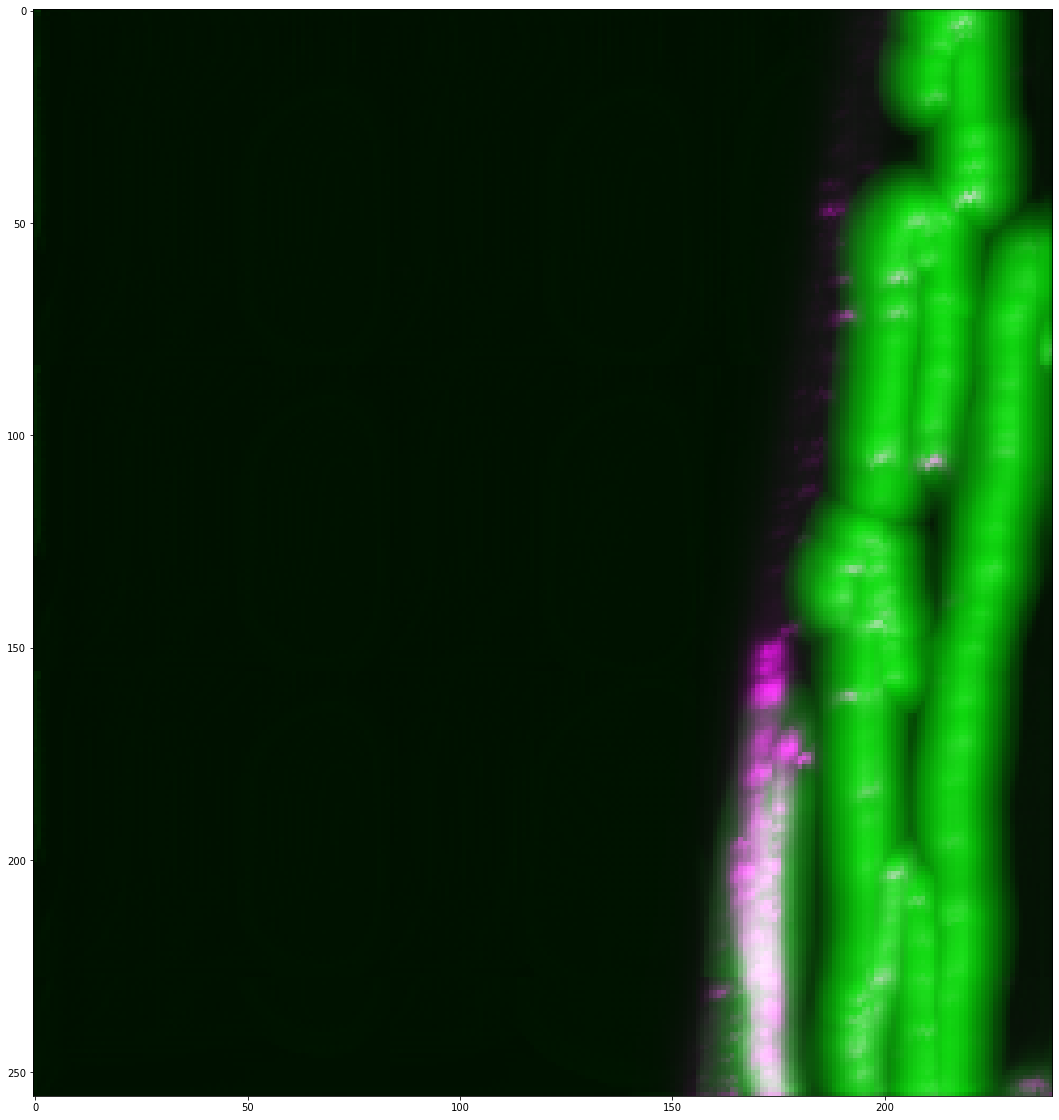

In [183]:
# Try on 1 cube
rgb_im = createRGB(getCube(175, [8, 35, 1])/65535, loadPred(175, [8, 35, 1]))

plt.figure(figsize=(20,20))
plt.imshow(rgb_im.astype('uint8').max(0))
plt.savefig("cube.png")

In [671]:
a = np.float32(getCube(175, [4, 39, 3])/65535)
b = loadPred(175, [4, 39, 3])
c = createRGB_clip_expo(a, b)
c.max()

31946

# Segmenting

In [156]:
#############    To change if not brain 175     #############
direc = "/cvlabdata2/home/zakariya/CarlsData/AL175/RES(15186x17117x1919)"

In [690]:
def segment_cubes(brain_i):
    
    cubes = findCubes(brain_i)
    dims = np.array(cubes).max(0) - np.array(cubes).min(0) +1
    maxs = np.array(cubes).max(0)
    mins = np.array(cubes).min(0)
    
    for i in tqdm(range(mins[0],maxs[0]+1)):
        for j in range(mins[1],maxs[1]+1):
            for k in range(mins[2],maxs[2]+1):
                
                print(i,j,k)
                im = np.float32(getCube(brain_i, [i,j,k])/65535)
                try:# if it is segmented load the prediction
                    pred_np = loadPred(brain_i, [i,j,k])
                    xs,ys,zs = getCubeCoords(brain_i)
                    x,y,z = [i,j,k]
                    l1 = "{:06d}".format(ys[y]*10)
                    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
                    l3 = "{:06d}_{:06d}_{:06d}.tif".format(ys[y]*10,xs[x]*10,zs[z]*10)
                    #rename old image with prediction
                    path = os.path.join(direc,l1,l2,l3)
                    os.rename(path, f'{path}_old')
                    
                    #create the prediction to save
                    rgb_pred = createRGB_clip_expo(im, pred_np)
                    #nt.utils.mkdir(os.path.join(direc,l1,l2))
                    tifffile.imsave(os.path.join(direc,l1,l2,l3), rgb_pred)
                    
                    print("Loaded and file name changed")
                except: # if it is an empty cube just put all 15 (because the highest value in distance map is 15)
                    pred_np = 15*np.ones(im.shape)              

In [691]:
segment_cubes(175)










  0%|                                                    | 0/38 [00:00<?, ?it/s]

4 30 1
4 30 2
4 30 3
4 30 4
4 31 1
4 31 2
4 31 3
4 31 4
4 32 1
4 32 2
4 32 3
4 32 4
4 33 1
4 33 2
4 33 3
4 33 4
4 34 1
4 34 2
4 34 3
4 34 4
4 35 1
4 35 2
4 35 3
4 35 4
4 36 1
4 36 2
4 36 3
4 36 4
4 37 1
4 37 2
4 37 3
4 37 4
4 38 1
4 38 2
4 38 3
4 38 4
4 39 1
4 39 2
4 39 3
Loaded and file name changed
4 39 4
4 40 1
4 40 2
4 40 3
Loaded and file name changed
4 40 4
4 41 1
4 41 2
4 41 3
4 41 4
4 42 1
4 42 2
4 42 3
4 42 4
4 43 1
4 43 2
4 43 3
4 43 4











  3%|█                                        | 1/38 [01:41<1:02:52, 101.97s/it]

5 30 1
5 30 2
5 30 3
5 30 4
5 31 1
5 31 2
5 31 3
5 31 4
5 32 1
5 32 2
5 32 3
5 32 4
5 33 1
5 33 2
5 33 3
5 33 4
5 34 1
5 34 2
5 34 3
5 34 4
5 35 1
5 35 2
5 35 3
5 35 4
5 36 1
5 36 2
5 36 3
5 36 4
5 37 1
5 37 2
5 37 3
5 37 4
5 38 1
5 38 2
5 38 3


/cvlabdata2/home/zakariya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Loaded and file name changed
5 38 4
5 39 1
5 39 2
5 39 3
Loaded and file name changed
5 39 4
5 40 1
5 40 2
5 40 3
Loaded and file name changed
5 40 4
Loaded and file name changed
5 41 1
5 41 2
5 41 3
5 41 4
5 42 1
5 42 2
5 42 3
5 42 4
5 43 1
5 43 2
5 43 3
5 43 4











  5%|██▏                                      | 2/38 [03:26<1:01:36, 102.67s/it]

6 30 1
6 30 2
6 30 3
6 30 4
6 31 1
6 31 2
6 31 3
6 31 4
6 32 1
6 32 2
6 32 3
6 32 4
6 33 1
6 33 2
6 33 3
6 33 4
6 34 1
6 34 2
6 34 3
6 34 4
6 35 1
6 35 2
6 35 3
6 35 4
6 36 1
6 36 2
Loaded and file name changed
6 36 3
6 36 4
6 37 1
6 37 2
6 37 3
6 37 4
6 38 1
6 38 2
Loaded and file name changed
6 38 3
Loaded and file name changed
6 38 4
6 39 1
6 39 2
Loaded and file name changed
6 39 3
Loaded and file name changed
6 39 4
6 40 1
6 40 2
6 40 3
6 40 4
6 41 1
6 41 2
6 41 3
6 41 4
6 42 1
6 42 2
6 42 3
6 42 4
6 43 1
6 43 2
6 43 3
6 43 4











  8%|███▏                                     | 3/38 [05:20<1:01:59, 106.28s/it]

7 30 1
7 30 2
7 30 3
7 30 4
7 31 1
7 31 2
7 31 3
7 31 4
7 32 1
7 32 2
7 32 3
7 32 4
7 33 1
7 33 2
7 33 3
7 33 4
7 34 1
7 34 2
7 34 3
7 34 4
7 35 1
Loaded and file name changed
7 35 2
Loaded and file name changed
7 35 3
7 35 4
7 36 1
Loaded and file name changed
7 36 2
Loaded and file name changed
7 36 3
7 36 4
7 37 1
Loaded and file name changed
7 37 2
Loaded and file name changed
7 37 3
7 37 4
7 38 1
Loaded and file name changed
7 38 2
Loaded and file name changed
7 38 3
Loaded and file name changed
7 38 4
7 39 1
7 39 2
Loaded and file name changed
7 39 3
Loaded and file name changed
7 39 4
7 40 1
7 40 2
7 40 3
7 40 4
7 41 1
7 41 2
7 41 3
7 41 4
7 42 1
7 42 2
7 42 3
7 42 4
7 43 1
7 43 2
7 43 3
7 43 4











 11%|████▎                                    | 4/38 [07:37<1:05:21, 115.34s/it]

8 30 1
8 30 2
8 30 3
8 30 4
8 31 1
8 31 2
8 31 3
8 31 4
8 32 1
Loaded and file name changed
8 32 2
Loaded and file name changed
8 32 3
8 32 4
8 33 1
Loaded and file name changed
8 33 2
Loaded and file name changed
8 33 3
8 33 4
8 34 1
Loaded and file name changed
8 34 2
Loaded and file name changed
8 34 3
8 34 4
Loaded and file name changed
8 35 1
Loaded and file name changed
8 35 2
Loaded and file name changed
8 35 3
8 35 4
8 36 1
Loaded and file name changed
8 36 2
Loaded and file name changed
8 36 3
8 36 4
8 37 1
Loaded and file name changed
8 37 2
Loaded and file name changed
8 37 3
8 37 4
8 38 1
Loaded and file name changed
8 38 2
Loaded and file name changed
8 38 3
8 38 4
8 39 1
8 39 2
8 39 3
Loaded and file name changed
8 39 4
8 40 1
8 40 2
8 40 3
8 40 4
8 41 1
8 41 2
8 41 3
8 41 4
8 42 1
8 42 2
8 42 3
8 42 4
8 43 1
8 43 2
8 43 3
8 43 4











 13%|█████▍                                   | 5/38 [10:22<1:11:37, 130.22s/it]

9 30 1
9 30 2
9 30 3
9 30 4
9 31 1
9 31 2
9 31 3
9 31 4
9 32 1
Loaded and file name changed
9 32 2
Loaded and file name changed
9 32 3
9 32 4
9 33 1
Loaded and file name changed
9 33 2
Loaded and file name changed
9 33 3
9 33 4
9 34 1
Loaded and file name changed
9 34 2
Loaded and file name changed
9 34 3
9 34 4
Loaded and file name changed
9 35 1
Loaded and file name changed
9 35 2
Loaded and file name changed
9 35 3
9 35 4
9 36 1
Loaded and file name changed
9 36 2
Loaded and file name changed
9 36 3
9 36 4
9 37 1
Loaded and file name changed
9 37 2
Loaded and file name changed
9 37 3
9 37 4
9 38 1
9 38 2
9 38 3
9 38 4
9 39 1
Loaded and file name changed
9 39 2
Loaded and file name changed
9 39 3
Loaded and file name changed
9 39 4
Loaded and file name changed
9 40 1
9 40 2
9 40 3
9 40 4
9 41 1
9 41 2
9 41 3
9 41 4
9 42 1
9 42 2
9 42 3
9 42 4
9 43 1
9 43 2
9 43 3
9 43 4











 16%|██████▍                                  | 6/38 [13:47<1:21:25, 152.66s/it]

10 30 1
Loaded and file name changed
10 30 2
10 30 3
10 30 4
10 31 1
Loaded and file name changed
10 31 2
Loaded and file name changed
10 31 3
10 31 4
10 32 1
Loaded and file name changed
10 32 2
10 32 3
10 32 4
10 33 1
Loaded and file name changed
10 33 2
10 33 3
10 33 4
10 34 1
Loaded and file name changed
10 34 2
Loaded and file name changed
10 34 3
Loaded and file name changed
10 34 4
Loaded and file name changed
10 35 1
Loaded and file name changed
10 35 2
Loaded and file name changed
10 35 3
Loaded and file name changed
10 35 4
10 36 1
Loaded and file name changed
10 36 2
Loaded and file name changed
10 36 3
Loaded and file name changed
10 36 4
10 37 1
Loaded and file name changed
10 37 2
Loaded and file name changed
10 37 3
10 37 4
10 38 1
Loaded and file name changed
10 38 2
Loaded and file name changed
10 38 3
10 38 4
10 39 1
10 39 2
Loaded and file name changed
10 39 3
Loaded and file name changed
10 39 4
10 40 1
10 40 2
10 40 3
10 40 4
10 41 1
10 41 2
10 41 3
10 41 4
10 42 1










 18%|███████▌                                 | 7/38 [18:28<1:38:43, 191.07s/it]

11 30 1
11 30 2
11 30 3
11 30 4
11 31 1
Loaded and file name changed
11 31 2
11 31 3
11 31 4
11 32 1
Loaded and file name changed
11 32 2
Loaded and file name changed
11 32 3
11 32 4
11 33 1
Loaded and file name changed
11 33 2
Loaded and file name changed
11 33 3
11 33 4
11 34 1
Loaded and file name changed
11 34 2
Loaded and file name changed
11 34 3
Loaded and file name changed
11 34 4
11 35 1
Loaded and file name changed
11 35 2
Loaded and file name changed
11 35 3
11 35 4
11 36 1
Loaded and file name changed
11 36 2
Loaded and file name changed
11 36 3
11 36 4
11 37 1
Loaded and file name changed
11 37 2
Loaded and file name changed
11 37 3
11 37 4
11 38 1
Loaded and file name changed
11 38 2
Loaded and file name changed
11 38 3
Loaded and file name changed
11 38 4
11 39 1
Loaded and file name changed
11 39 2
Loaded and file name changed
11 39 3
Loaded and file name changed
11 39 4
11 40 1
11 40 2
11 40 3
11 40 4
11 41 1
11 41 2
11 41 3
11 41 4
11 42 1
Loaded and file name changed










 21%|████████▋                                | 8/38 [22:27<1:42:51, 205.70s/it]

12 30 1
12 30 2
Loaded and file name changed
12 30 3
Loaded and file name changed
12 30 4
12 31 1
12 31 2
Loaded and file name changed
12 31 3
12 31 4
12 32 1
12 32 2
Loaded and file name changed
12 32 3
Loaded and file name changed
12 32 4
12 33 1
Loaded and file name changed
12 33 2
Loaded and file name changed
12 33 3
12 33 4
12 34 1
Loaded and file name changed
12 34 2
Loaded and file name changed
12 34 3
Loaded and file name changed
12 34 4
12 35 1
Loaded and file name changed
12 35 2
Loaded and file name changed
12 35 3
Loaded and file name changed
12 35 4
12 36 1
Loaded and file name changed
12 36 2
Loaded and file name changed
12 36 3
12 36 4
12 37 1
Loaded and file name changed
12 37 2
Loaded and file name changed
12 37 3
12 37 4
12 38 1
Loaded and file name changed
12 38 2
Loaded and file name changed
12 38 3
Loaded and file name changed
12 38 4
12 39 1
Loaded and file name changed
12 39 2
Loaded and file name changed
12 39 3
Loaded and file name changed
12 39 4
12 40 1
12 40










 24%|█████████▋                               | 9/38 [26:58<1:48:47, 225.10s/it]

13 30 1
13 30 2
Loaded and file name changed
13 30 3
13 30 4
13 31 1
13 31 2
Loaded and file name changed
13 31 3
Loaded and file name changed
13 31 4
13 32 1
13 32 2
Loaded and file name changed
13 32 3
13 32 4
13 33 1
13 33 2
Loaded and file name changed
13 33 3
13 33 4
13 34 1
13 34 2
Loaded and file name changed
13 34 3
13 34 4
13 35 1
Loaded and file name changed
13 35 2
Loaded and file name changed
13 35 3
13 35 4
13 36 1
Loaded and file name changed
13 36 2
Loaded and file name changed
13 36 3
13 36 4
13 37 1
Loaded and file name changed
13 37 2
Loaded and file name changed
13 37 3
13 37 4
13 38 1
13 38 2
13 38 3
13 38 4
13 39 1
13 39 2
13 39 3
13 39 4
13 40 1
13 40 2
13 40 3
13 40 4
13 41 1
13 41 2
13 41 3
13 41 4
13 42 1
Loaded and file name changed
13 42 2
13 42 3
13 42 4
13 43 1
Loaded and file name changed
13 43 2
Loaded and file name changed
13 43 3
13 43 4











 26%|██████████▌                             | 10/38 [29:51<1:37:48, 209.59s/it]

14 30 1
14 30 2
14 30 3
14 30 4
14 31 1
14 31 2
Loaded and file name changed
14 31 3
14 31 4
14 32 1
Loaded and file name changed
14 32 2
Loaded and file name changed
14 32 3
14 32 4
14 33 1
Loaded and file name changed
14 33 2
Loaded and file name changed
14 33 3
14 33 4
14 34 1
14 34 2
Loaded and file name changed
14 34 3
14 34 4
14 35 1
14 35 2
Loaded and file name changed
14 35 3
14 35 4
14 36 1
14 36 2
Loaded and file name changed
14 36 3
14 36 4
14 37 1
14 37 2
14 37 3
14 37 4
14 38 1
Loaded and file name changed
14 38 2
14 38 3
14 38 4
14 39 1
Loaded and file name changed
14 39 2
14 39 3
14 39 4
14 40 1
14 40 2
14 40 3
14 40 4
14 41 1
Loaded and file name changed
15 38 2
15 38 3
15 38 4
15 39 1
Loaded and file name changed
15 39 2
15 39 3
15 39 4
15 40 1
Loaded and file name changed
15 40 2
15 40 3
15 40 4
15 41 1
Loaded and file name changed
15 41 2
15 41 3
15 41 4
15 42 1
Loaded and file name changed
15 42 2
15 42 3
15 42 4
15 43 1
Loaded and file name changed
15 43 2
15 43 3











 32%|████████████▋                           | 12/38 [35:04<1:19:05, 182.51s/it]

16 30 1
16 30 2
16 30 3
16 30 4
16 31 1
16 31 2
16 31 3
16 31 4
16 32 1
16 32 2
16 32 3
16 32 4
16 33 1
16 33 2
16 33 3
16 33 4
16 34 1
Loaded and file name changed
16 34 2
16 34 3
16 34 4
16 35 1
Loaded and file name changed
16 35 2
Loaded and file name changed
16 35 3
16 35 4
16 36 1
Loaded and file name changed
16 36 2
16 36 3
16 36 4
16 37 1
Loaded and file name changed
16 37 2
16 37 3
16 37 4
16 38 1
Loaded and file name changed
16 38 2
16 38 3
16 38 4
16 39 1
Loaded and file name changed
16 39 2
16 39 3
16 39 4
16 40 1
Loaded and file name changed
16 40 2
16 40 3
16 40 4
16 41 1
Loaded and file name changed
16 41 2
16 41 3
16 41 4
16 42 1
Loaded and file name changed
16 42 2
16 42 3
16 42 4
16 43 1
Loaded and file name changed
16 43 2
16 43 3
16 43 4











 34%|█████████████▋                          | 13/38 [37:55<1:14:37, 179.10s/it]

17 30 1
17 30 2
17 30 3
17 30 4
17 31 1
Loaded and file name changed
17 31 2
17 31 3
17 31 4
17 32 1
Loaded and file name changed
17 32 2
17 32 3
17 32 4
17 33 1
17 33 2
17 33 3
17 33 4
17 34 1
Loaded and file name changed
17 34 2
Loaded and file name changed
17 34 3
17 34 4
17 35 1
Loaded and file name changed
17 35 2
Loaded and file name changed
17 35 3
17 35 4
17 36 1
Loaded and file name changed
17 36 2
17 36 3
17 36 4
17 37 1
Loaded and file name changed
17 37 2
17 37 3
17 37 4
17 38 1
Loaded and file name changed
17 38 2
17 38 3
17 38 4
17 39 1
Loaded and file name changed
17 39 2
17 39 3
17 39 4
17 40 1
Loaded and file name changed
17 40 2
17 40 3
17 40 4
17 41 1
Loaded and file name changed
17 41 2
17 41 3
17 41 4
17 42 1
Loaded and file name changed
17 42 2
17 42 3
17 42 4
17 43 1
17 43 2
17 43 3
17 43 4











 37%|██████████████▋                         | 14/38 [40:19<1:07:23, 168.49s/it]

18 30 1
18 30 2
18 30 3
18 30 4
18 31 1
Loaded and file name changed
18 31 2
18 31 3
18 31 4
18 32 1
Loaded and file name changed
18 32 2
18 32 3
18 32 4
18 33 1
Loaded and file name changed
18 33 2
18 33 3
18 33 4
18 34 1
Loaded and file name changed
18 34 2
Loaded and file name changed
18 34 3
18 34 4
18 35 1
Loaded and file name changed
18 35 2
18 35 3
18 35 4
18 36 1
Loaded and file name changed
18 36 2
18 36 3
18 36 4
18 37 1
Loaded and file name changed
18 37 2
18 37 3
18 37 4
18 38 1
Loaded and file name changed
18 38 2
18 38 3
18 38 4
18 39 1
Loaded and file name changed
18 39 2
18 39 3
18 39 4
18 40 1
Loaded and file name changed
18 40 2
18 40 3
18 40 4
18 41 1
Loaded and file name changed
18 41 2
18 41 3
18 41 4
18 42 1
18 42 2
18 42 3
18 42 4
18 43 1
18 43 2
18 43 3
18 43 4











 39%|███████████████▊                        | 15/38 [44:06<1:11:15, 185.88s/it]

19 30 1
19 30 2
19 30 3
19 30 4
19 31 1
Loaded and file name changed
19 31 2
19 31 3
19 31 4
19 32 1
Loaded and file name changed
19 32 2
19 32 3
19 32 4
19 33 1
Loaded and file name changed
19 33 2
19 33 3
19 33 4
19 34 1
Loaded and file name changed
19 34 2
Loaded and file name changed
19 34 3
19 34 4
19 35 1
19 35 2
19 35 3
19 35 4
19 36 1
19 36 2
19 36 3
19 36 4
19 37 1
19 37 2
19 37 3
19 37 4
19 38 1
Loaded and file name changed
19 38 2
19 38 3
19 38 4
19 39 1
Loaded and file name changed
19 39 2
19 39 3
19 39 4
19 40 1
19 40 2
19 40 3
19 40 4
19 41 1
Loaded and file name changed
19 41 2
19 41 3
19 41 4
19 42 1
19 42 2
19 42 3
19 42 4
19 43 1
19 43 2
19 43 3
19 43 4











 42%|████████████████▊                       | 16/38 [46:29<1:03:27, 173.07s/it]

20 30 1
20 30 2
20 30 3
20 30 4
20 31 1
20 31 2
20 31 3
20 31 4
20 32 1
20 32 2
20 32 3
20 32 4
20 33 1
Loaded and file name changed
20 33 2
20 33 3
20 33 4
20 34 1
Loaded and file name changed
20 34 2
Loaded and file name changed
20 34 3
20 34 4
20 35 1
20 35 2
20 35 3
20 35 4
20 36 1
20 36 2
20 36 3
20 36 4
20 37 1
20 37 2
20 37 3
20 37 4
20 38 1
20 38 2
20 38 3
20 38 4
20 39 1
20 39 2
20 39 3
20 39 4
20 40 1
20 40 2
20 40 3
20 40 4
20 41 1
20 41 2
20 41 3
20 41 4
20 42 1
20 42 2
20 42 3
20 42 4
20 43 1
20 43 2
20 43 3
20 43 4











 45%|██████████████████▊                       | 17/38 [48:45<56:44, 162.12s/it]

21 30 1
21 30 2
21 30 3
21 30 4
21 31 1
21 31 2
21 31 3
21 31 4
21 32 1
21 32 2
21 32 3
21 32 4
21 33 1
Loaded and file name changed
21 33 2
21 33 3
21 33 4
21 34 1
Loaded and file name changed
21 34 2
21 34 3
21 34 4
21 35 1
21 35 2
21 35 3
21 35 4
21 36 1
21 36 2
21 36 3
21 36 4
21 37 1
21 37 2
21 37 3
21 37 4
21 38 1
21 38 2
21 38 3
21 38 4
21 39 1
21 39 2
21 39 3
21 39 4
21 40 1
21 40 2
21 40 3
21 40 4
21 41 1
21 41 2
21 41 3
21 41 4
21 42 1
21 42 2
21 42 3
21 42 4
21 43 1
21 43 2
21 43 3
21 43 4











 47%|███████████████████▉                      | 18/38 [50:41<49:21, 148.06s/it]

22 30 1
22 30 2
22 30 3
22 30 4
22 31 1
22 31 2
22 31 3
22 31 4
22 32 1
22 32 2
22 32 3
22 32 4
22 33 1
Loaded and file name changed
22 33 2
22 33 3
22 33 4
22 34 1
Loaded and file name changed
22 34 2
22 34 3
22 34 4
22 35 1
22 35 2
22 35 3
22 35 4
22 36 1
22 36 2
22 36 3
22 36 4
22 37 1
22 37 2
22 37 3
22 37 4
22 38 1
22 38 2
22 38 3
22 38 4
22 39 1
22 39 2
22 39 3
22 39 4
22 40 1
22 40 2
22 40 3
22 40 4
22 41 1
22 41 2
22 41 3
22 41 4
22 42 1
22 42 2
22 42 3
22 42 4
22 43 1
22 43 2
22 43 3
22 43 4











 50%|█████████████████████                     | 19/38 [52:58<45:49, 144.73s/it]

23 30 1
23 30 2
23 30 3
23 30 4
23 31 1
23 31 2
23 31 3
23 31 4
23 32 1
23 32 2
23 32 3
23 32 4
23 33 1
23 33 2
23 33 3
23 33 4
23 34 1
Loaded and file name changed
23 34 2
23 34 3
23 34 4
23 35 1
23 35 2
23 35 3
23 35 4
23 36 1
23 36 2
23 36 3
23 36 4
23 37 1
23 37 2
23 37 3
23 37 4
23 38 1
23 38 2
23 38 3
23 38 4
23 39 1
23 39 2
23 39 3
23 39 4
23 40 1
23 40 2
23 40 3
23 40 4
23 41 1
23 41 2
23 41 3
23 41 4
23 42 1
23 42 2
23 42 3
23 42 4
23 43 1
23 43 2
23 43 3
23 43 4











 53%|██████████████████████                    | 20/38 [54:57<41:10, 137.23s/it]

24 30 1
24 30 2
24 30 3
24 30 4
24 31 1
24 31 2
24 31 3
24 31 4
24 32 1
24 32 2
24 32 3
24 32 4
24 33 1
24 33 2
24 33 3
24 33 4
24 34 1
Loaded and file name changed
24 34 2
24 34 3
24 34 4
24 35 1
24 35 2
24 35 3
24 35 4
24 36 1
24 36 2
24 36 3
24 36 4
24 37 1
24 37 2
24 37 3
24 37 4
24 38 1
24 38 2
24 38 3
24 38 4
24 39 1
24 39 2
24 39 3
24 39 4
24 40 1
24 40 2
24 40 3
24 40 4
24 41 1
24 41 2
24 41 3
24 41 4
24 42 1
24 42 2
24 42 3
24 42 4
24 43 1
24 43 2
24 43 3
24 43 4











 55%|███████████████████████▏                  | 21/38 [56:55<37:13, 131.40s/it]

25 30 1
25 30 2
25 30 3
25 30 4
25 31 1
25 31 2
25 31 3
25 31 4
25 32 1
25 32 2
25 32 3
25 32 4
25 33 1
Loaded and file name changed
25 33 2
25 33 3
25 33 4
25 34 1
Loaded and file name changed
25 34 2
25 34 3
25 34 4
25 35 1
25 35 2
25 35 3
25 35 4
25 36 1
25 36 2
25 36 3
25 36 4
25 37 1
25 37 2
25 37 3
25 37 4
25 38 1
25 38 2
25 38 3
25 38 4
25 39 1
25 39 2
26 36 2
26 36 3
26 36 4
26 37 1
26 37 2
26 37 3
26 37 4
26 38 1
26 38 2
26 38 3
26 38 4
26 39 1
26 39 2
26 39 3
26 39 4
26 40 1
26 40 2
26 40 3
26 40 4
26 41 1
26 41 2
26 41 3
26 41 4
26 42 1
26 42 2
26 42 3
26 42 4
26 43 1
26 43 2
26 43 3
26 43 4











 61%|████████████████████████▏               | 23/38 [1:00:31<29:43, 118.90s/it]

27 30 1
27 30 2
27 30 3
27 30 4
27 31 1
27 31 2
27 31 3
27 31 4
27 32 1
27 32 2
27 32 3
27 32 4
27 33 1
27 33 2
27 33 3
27 33 4
27 34 1
Loaded and file name changed
27 34 2
27 34 3
27 34 4
27 35 1
27 35 2
27 35 3
27 35 4
27 36 1
27 36 2
27 36 3
27 36 4
27 37 1
27 37 2
27 37 3
27 37 4
27 38 1
27 38 2
27 38 3
27 38 4
27 39 1
27 39 2
27 39 3
27 39 4
27 40 1
27 40 2
27 40 3
27 40 4
27 41 1
27 41 2
27 41 3
27 41 4
27 42 1
27 42 2
27 42 3
27 42 4
27 43 1
27 43 2
27 43 3
27 43 4











 63%|█████████████████████████▎              | 24/38 [1:02:14<26:38, 114.14s/it]

28 30 1
28 30 2
28 30 3
28 30 4
28 31 1
28 31 2
28 31 3
28 31 4
28 32 1
28 32 2
28 32 3
28 32 4
28 33 1
28 33 2
28 33 3
28 33 4
28 34 1
Loaded and file name changed
28 34 2
Loaded and file name changed
28 34 3
28 34 4
28 35 1
28 35 2
28 35 3
28 35 4
28 36 1
28 36 2
28 36 3
28 36 4
28 37 1
28 37 2
28 37 3
28 37 4
28 38 1
28 38 2
28 38 3
28 38 4
28 39 1
28 39 2
28 39 3
28 39 4
28 40 1
28 40 2
28 40 3
28 40 4
28 41 1
28 41 2
28 41 3
28 41 4
28 42 1
28 42 2
28 42 3
28 42 4
28 43 1
28 43 2
28 43 3
28 43 4











 66%|██████████████████████████▎             | 25/38 [1:04:02<24:19, 112.27s/it]

29 30 1
29 30 2
29 30 3
29 30 4
29 31 1
29 31 2
29 31 3
29 31 4
29 32 1
29 32 2
29 32 3
29 32 4
29 33 1
29 33 2
Loaded and file name changed
29 33 3
29 33 4
29 34 1
Loaded and file name changed
29 34 2
Loaded and file name changed
29 34 3
29 34 4
29 35 1
29 35 2
29 35 3
29 35 4
29 36 1
29 36 2
29 36 3
29 36 4
29 37 1
29 37 2
29 37 3
29 37 4
29 38 1
29 38 2
29 38 3
29 38 4
29 39 1
29 39 2
29 39 3
29 39 4
29 40 1
29 40 2
29 40 3
29 40 4
29 41 1
29 41 2
29 41 3
29 41 4
29 42 1
29 42 2
29 42 3
29 42 4
29 43 1
29 43 2
29 43 3
29 43 4











 68%|███████████████████████████▎            | 26/38 [1:05:48<22:03, 110.26s/it]

30 30 1
30 30 2
30 30 3
30 30 4
30 31 1
30 31 2
30 31 3
30 31 4
30 32 1
30 32 2
30 32 3
30 32 4
30 33 1
30 33 2
Loaded and file name changed
30 33 3
30 33 4
30 34 1
30 34 2
Loaded and file name changed
30 34 3
30 34 4
30 35 1
30 35 2
30 35 3
30 35 4
30 36 1
30 36 2
30 36 3
30 36 4
30 37 1
30 37 2
30 37 3
30 37 4
30 38 1
30 38 2
30 38 3
30 38 4
30 39 1
30 39 2
30 39 3
30 39 4
30 40 1
30 40 2
30 40 3
30 40 4
30 41 1
30 41 2
30 41 3
30 41 4
30 42 1
30 42 2
30 42 3
30 42 4
30 43 1
30 43 2
30 43 3
30 43 4











 71%|████████████████████████████▍           | 27/38 [1:07:32<19:54, 108.60s/it]

31 30 1
31 30 2
31 30 3
31 30 4
31 31 1
31 31 2
31 31 3
31 31 4
31 32 1
31 32 2
Loaded and file name changed
31 32 3
31 32 4
31 33 1
31 33 2
Loaded and file name changed
31 33 3
Loaded and file name changed
31 33 4
31 34 1
31 34 2
Loaded and file name changed
31 34 3
31 34 4
31 35 1
31 35 2
31 35 3
31 35 4
31 36 1
31 36 2
31 36 3
31 36 4
31 37 1
31 37 2
31 37 3
31 37 4
31 38 1
31 38 2
31 38 3
31 38 4
31 39 1
31 39 2
31 39 3
31 39 4
31 40 1
31 40 2
31 40 3
31 40 4
31 41 1
31 41 2
31 41 3
31 41 4
31 42 1
31 42 2
31 42 3
31 42 4
31 43 1
31 43 2
31 43 3
31 43 4











 74%|█████████████████████████████▍          | 28/38 [1:09:26<18:20, 110.05s/it]

32 30 1
32 30 2
32 30 3
32 30 4
32 31 1
32 31 2
32 31 3
32 31 4
32 32 1
32 32 2
32 32 3
32 32 4
32 33 1
32 33 2
Loaded and file name changed
32 33 3
Loaded and file name changed
32 33 4
32 34 1
32 34 2
32 34 3
32 34 4
32 35 1
32 35 2
32 35 3
32 35 4
32 36 1
32 36 2
32 36 3
32 36 4
32 37 1
32 37 2
32 37 3
32 37 4
32 38 1
32 38 2
32 38 3
32 38 4
32 39 1
32 39 2
32 39 3
32 39 4
32 40 1
32 40 2
32 40 3
32 40 4
32 41 1
32 41 2
32 41 3
32 41 4
32 42 1
32 42 2
32 42 3
32 42 4
32 43 1
32 43 2
32 43 3
32 43 4











 76%|██████████████████████████████▌         | 29/38 [1:11:10<16:14, 108.27s/it]

33 30 1
33 30 2
33 30 3
33 30 4
33 31 1
33 31 2
33 31 3
33 31 4
33 32 1
33 32 2
33 32 3
33 32 4
33 33 1
Loaded and file name changed
33 33 2
Loaded and file name changed
33 33 3
33 33 4
33 34 1
33 34 2
33 34 3
33 34 4
33 35 1
33 35 2
33 35 3
33 35 4
33 36 1
33 36 2
33 36 3
33 36 4
33 37 1
33 37 2
33 37 3
33 37 4
33 38 1
33 38 2
33 38 3
33 38 4
33 39 1
33 39 2
33 39 3
33 39 4
33 40 1
33 40 2
33 40 3
33 40 4
33 41 1
33 41 2
33 41 3
33 41 4
33 42 1
33 42 2
33 42 3
33 42 4
33 43 1
33 43 2
33 43 3
33 43 4











 79%|███████████████████████████████▌        | 30/38 [1:12:51<14:09, 106.13s/it]

34 30 1
34 30 2
34 30 3
34 30 4
34 31 1
34 31 2
34 31 3
34 31 4
34 32 1
Loaded and file name changed
34 32 2
Loaded and file name changed
34 32 3
34 32 4
34 33 1
Loaded and file name changed
34 33 2
Loaded and file name changed
34 33 3
34 33 4
34 34 1
34 34 2
34 34 3
34 34 4
34 35 1
34 35 2
34 35 3
34 35 4
34 36 1
34 36 2
34 36 3
34 36 4
34 37 1
34 37 2
34 37 3
34 37 4
34 38 1
34 38 2
34 38 3
34 38 4
34 39 1
34 39 2
34 39 3
34 39 4
34 40 1
34 40 2
34 40 3
34 40 4
34 41 1
34 41 2
34 41 3
34 41 4
34 42 1
34 42 2
34 42 3
34 42 4
34 43 1
34 43 2
34 43 3
34 43 4











 82%|████████████████████████████████▋       | 31/38 [1:14:37<12:23, 106.22s/it]

35 30 1
35 30 2
35 30 3
35 30 4
35 31 1
35 31 2
35 31 3
35 31 4
35 32 1
Loaded and file name changed
35 32 2
35 32 3
35 32 4
35 33 1
35 33 2
35 33 3
35 33 4
35 34 1
35 34 2
35 34 3
35 34 4
35 35 1
35 35 2
35 35 3
35 35 4
35 36 1
35 36 2
35 36 3
35 36 4
35 37 1
35 37 2
35 37 3
35 37 4
35 38 1
35 38 2
35 38 3
35 38 4
35 39 1
35 39 2
35 39 3
35 39 4
35 40 1
35 40 2
35 40 3
35 40 4
35 41 1
35 41 2
35 41 3
35 41 4
35 42 1
35 42 2
35 42 3
35 42 4
35 43 1
35 43 2
35 43 3
35 43 4











 84%|█████████████████████████████████▋      | 32/38 [1:16:15<10:21, 103.61s/it]

36 30 1
36 30 2
36 30 3
36 30 4
36 31 1
Loaded and file name changed
36 31 2
36 31 3
36 31 4
36 32 1
Loaded and file name changed
36 32 2
36 32 3
36 32 4
36 33 1
36 33 2
36 33 3
36 33 4
36 34 1
36 34 2
36 34 3
36 34 4
36 35 1
36 35 2
36 35 3
36 35 4
36 36 1
36 36 2
36 36 3
36 36 4
36 37 1
36 37 2
36 37 3
36 37 4
36 38 1
36 38 2
36 38 3
36 38 4
36 39 1
36 39 2
36 39 3
36 39 4
36 40 1
36 40 2
36 40 3
36 40 4
36 41 1
36 41 2
36 41 3
36 41 4
36 42 1
36 42 2
36 42 3
36 42 4
36 43 1
36 43 2
36 43 3
36 43 4











 87%|██████████████████████████████████▋     | 33/38 [1:17:55<08:33, 102.62s/it]

37 30 1
37 30 2
37 30 3
37 30 4
37 31 1
Loaded and file name changed
37 31 2
37 31 3
37 31 4
37 32 1
37 32 2
37 32 3
37 32 4
37 33 1
37 33 2
37 33 3
37 33 4
37 34 1
37 34 2
37 34 3
37 34 4
37 35 1
37 35 2
37 35 3
37 35 4
37 36 1
37 36 2
37 36 3
37 36 4
37 37 1
37 37 2
37 37 3
37 37 4
37 38 1
37 38 2
37 38 3
37 38 4
37 39 1
37 39 2
37 39 3
37 39 4
37 40 1
37 40 2
37 40 3
37 40 4
37 41 1
37 41 2
37 41 3
37 41 4
37 42 1
37 42 2
37 42 3
37 42 4
37 43 1
37 43 2
37 43 3
37 43 4











 89%|███████████████████████████████████▊    | 34/38 [1:19:32<06:43, 100.98s/it]

38 30 1
38 30 2
38 30 3
38 30 4
38 31 1
Loaded and file name changed
38 31 2
38 31 3
38 31 4
38 32 1
38 32 2
38 32 3
38 32 4
38 33 1
38 33 2
38 33 3
38 33 4
38 34 1
38 34 2
38 34 3
38 34 4
38 35 1
38 35 2
38 35 3
38 35 4
38 36 1
38 36 2
38 36 3
38 36 4
38 37 1
38 37 2
38 37 3
38 37 4
38 38 1
38 38 2
38 38 3
38 38 4
38 39 1
38 39 2
38 39 3
38 39 4
38 40 1
38 40 2
38 40 3
38 40 4
38 41 1
38 41 2
38 41 3
38 41 4
38 42 1
38 42 2
38 42 3
38 42 4
38 43 1
38 43 2
38 43 3
38 43 4











 92%|█████████████████████████████████████▊   | 35/38 [1:21:07<04:56, 98.92s/it]

39 30 1
39 30 2
39 30 3
39 30 4
39 31 1
Loaded and file name changed
39 31 2
39 31 3
39 31 4
39 32 1
39 32 2
39 32 3
39 32 4
39 33 1
39 33 2
39 33 3
39 33 4
39 34 1
39 34 2
39 34 3
39 34 4
39 35 1
39 35 2
39 35 3
39 35 4
39 36 1
39 36 2
39 36 3
39 36 4
39 37 1
39 37 2
39 37 3
39 37 4
39 38 1
39 38 2
39 38 3
39 38 4
39 39 1
39 39 2
39 39 3
39 39 4
39 40 1
39 40 2
39 40 3
39 40 4
39 41 1
39 41 2
39 41 3
39 41 4
39 42 1
39 42 2
39 42 3
39 42 4
39 43 1
39 43 2
39 43 3
39 43 4











 95%|██████████████████████████████████████▊  | 36/38 [1:22:44<03:17, 98.53s/it]

40 30 1
40 30 2
40 30 3
40 30 4
40 31 1
Loaded and file name changed
40 31 2
40 31 3
40 31 4
40 32 1
40 32 2
40 32 3
40 32 4
40 33 1
40 33 2
40 33 3
40 33 4
40 34 1
40 34 2
40 34 3
40 34 4
40 35 1
40 35 2
40 35 3
40 35 4
40 36 1
40 36 2
40 36 3
40 36 4
40 37 1
40 37 2
40 37 3
40 37 4
40 38 1
40 38 2
40 38 3
40 38 4
40 39 1
40 39 2
40 39 3
40 39 4
40 40 1
40 40 2
40 40 3
40 40 4
40 41 1
40 41 2
40 41 3
40 41 4
40 42 1
40 42 2
40 42 3
40 42 4
40 43 1
40 43 2
40 43 3
40 43 4











 97%|███████████████████████████████████████▉ | 37/38 [1:24:18<01:37, 97.03s/it]

41 30 1
41 30 2
41 30 3
41 30 4
41 31 1
Loaded and file name changed
41 31 2
41 31 3
41 31 4
41 32 1
41 32 2
41 32 3
41 32 4
41 33 1
41 33 2
41 33 3
41 33 4
41 34 1
41 34 2
41 34 3
41 34 4
41 35 1
41 35 2
41 35 3
41 35 4
41 36 1
41 36 2
41 36 3
41 36 4
41 37 1
41 37 2
41 37 3
41 37 4
41 38 1
41 38 2
41 38 3
41 38 4
41 39 1
41 39 2
41 39 3
41 39 4
41 40 1
41 40 2
41 40 3
41 40 4
41 41 1
41 41 2
41 41 3
41 41 4
41 42 1
41 42 2
41 42 3
41 42 4
41 43 1
41 43 2
41 43 3
41 43 4











100%|████████████████████████████████████████| 38/38 [1:25:57<00:00, 135.72s/it]


In [692]:
xs,ys,zs = getCubeCoords(175)
x,y,z = [8, 35, 1]
(ys[y]*10,xs[x]*10,zs[z]*10)

(88610, 20480, 2400)

In [209]:
t = getCube(175, [8, 35, 1])/65535
t = t*255
t.shape

(253, 256, 240)

In [222]:
v = tifffile.imread('/cvlabdata2/home/zakariya/CarlsData/AL175/RES(15186x17117x1919)/088610/088610_020480/088610_020480_002400_old.tif')
v.shape

(240, 253, 256)

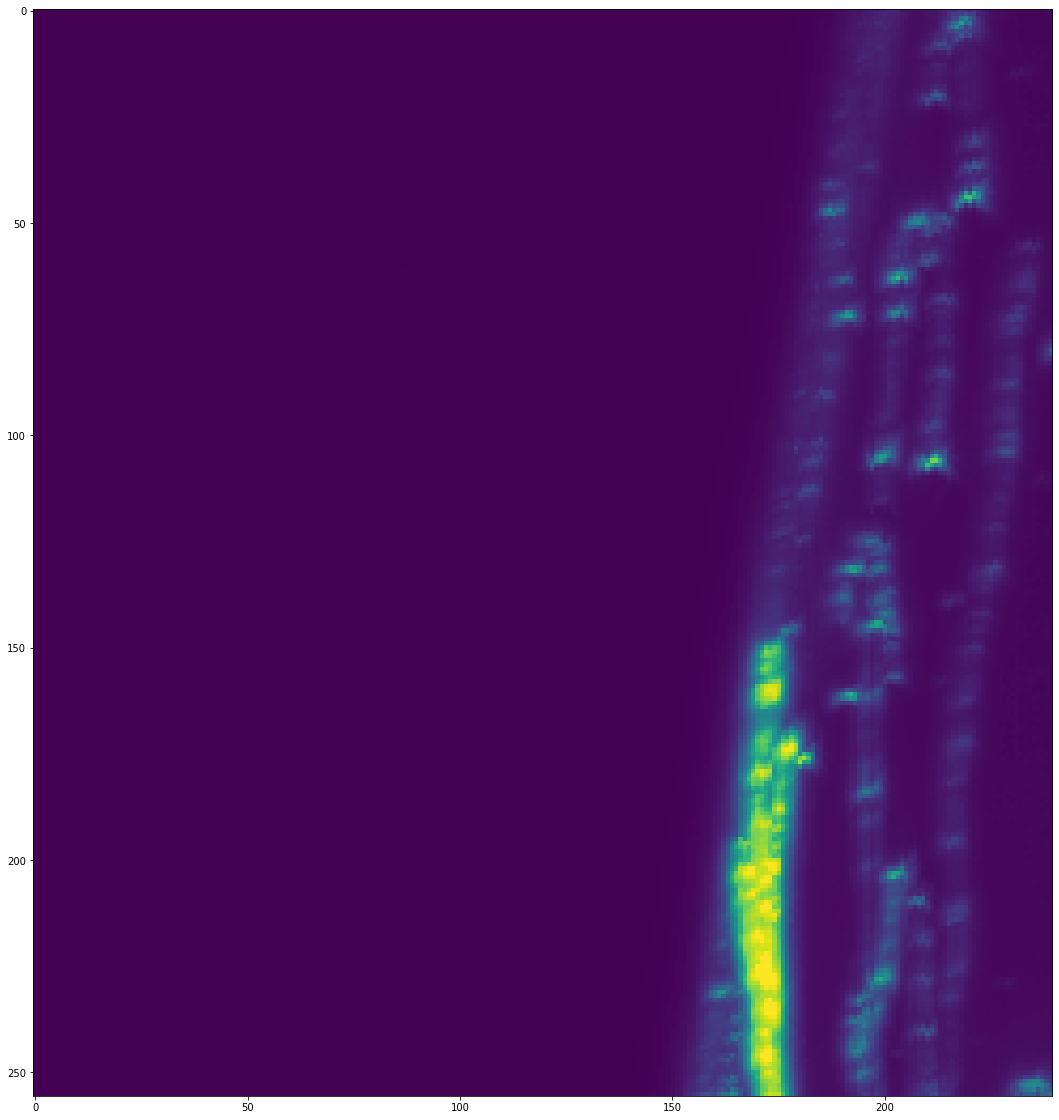

In [225]:
plt.figure(figsize=(20,20))
plt.imshow(t.astype('uint8').max(0))

# Tests

In [586]:
im1.max()

65535

In [701]:
def createRGB1_clip_expo(im, pred, lmbd=0.5):
    
    g_channel = np.clip(pred, a_min=pred.min(), a_max=6)
    g_channel = np.array((g_channel.max() - g_channel)/g_channel.max())
    g_channel = np.power(g_channel, 2)
    g_channel /= g_channel.max()
    
    
    finalim = np.zeros((im.shape[0], im.shape[1], im.shape[2], 3))
    finalim[:,:,:,0] = im.astype(np.int16)
    finalim[:,:,:,2] = im.astype(np.int16)
    finalim[:,:,:,1] = (g_channel * 65535 * 0.8).astype(np.int16)
    
    return finalim.astype(np.int16)

In [702]:
im1 = getCube(175, [8, 35, 1])
pred1 = loadPred(175, [8, 35, 1])

rgb_pred1 = createRGB1_clip_expo(im1, pred1)
tifffile.imsave('/cvlabdata2/home/zakariya/cube_test.tif', rgb_pred1)

In [703]:
rgb_pred1 = rgb_pred1/rgb_pred1.max()
#rgb_pred1 = rgb_pred1*255
#rgb_pred1 = rgb_pred1.astype(np.int16)

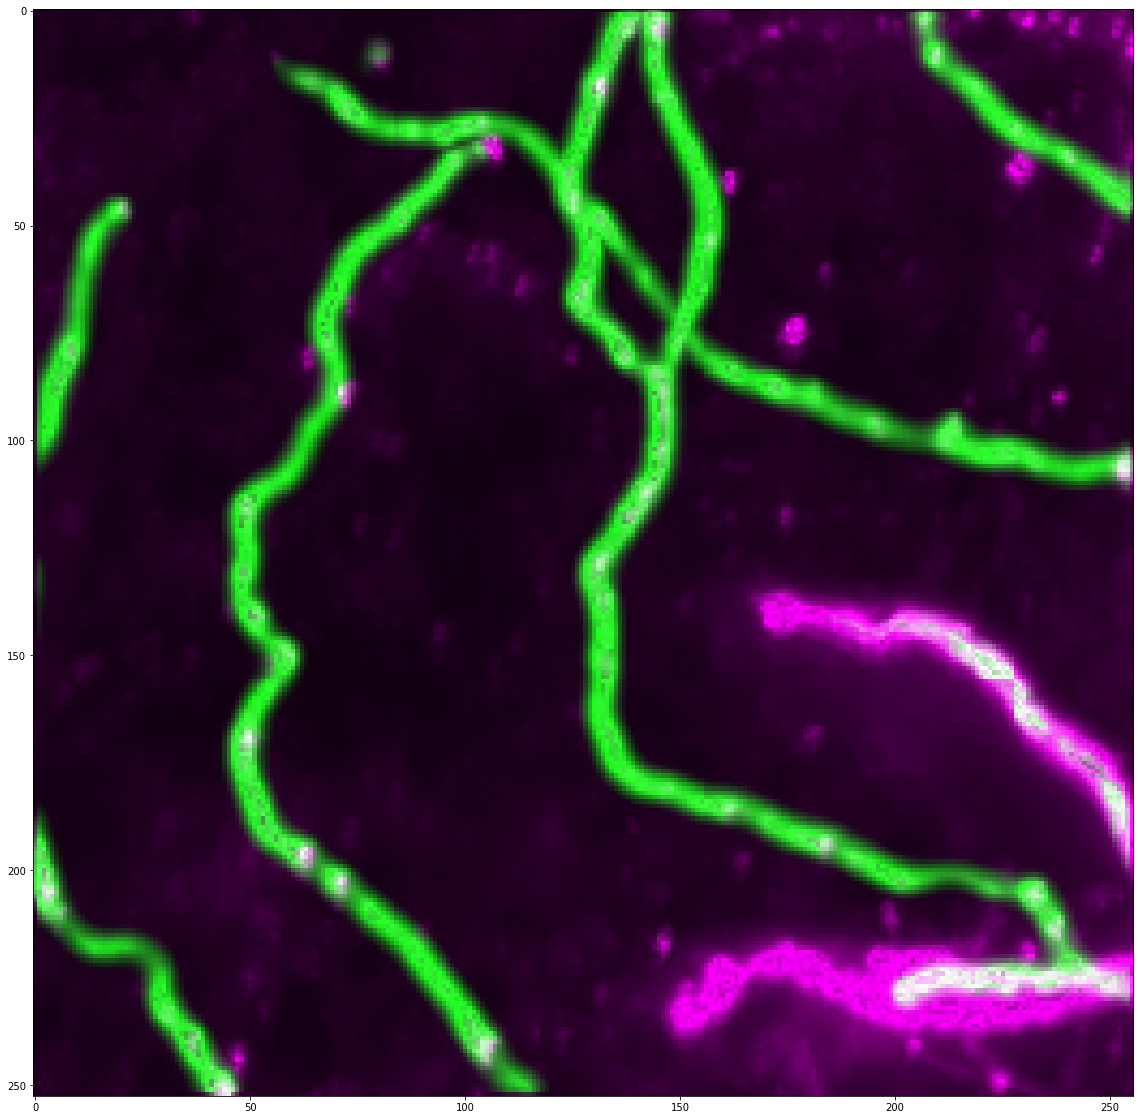

In [704]:
plt.figure(figsize=(20,20))
plt.imshow(rgb_pred1.max(2))